In [11]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [2]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


# Feat5 IVAC

In [9]:
ivac_trajs = np.load("../../data/raw_feat/feat5_ivac_anton2_3.npy", allow_pickle=True)

In [10]:
ivac_arr = np.concatenate(ivac_trajs)

## 200 cluster

In [12]:
traj_inds = util.split_indices(cv_trajs)

In [13]:
dtrajs = np.split(np.squeeze(np.load("../../data/raw_feat/feat5_ivac_ind200_anton2_3.npy", allow_pickle=True)), traj_inds)

In [14]:
len(dtrajs), dtrajs[-1].shape

(352, (10001,))

In [20]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 7500]
its = pyemma.msm.its(dtrajs, lags=lags, reversible=True, n_jobs=48, errors='bayes')

100%|██████████| 13/13 [01:27<00:00,  6.72s/it]                        


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

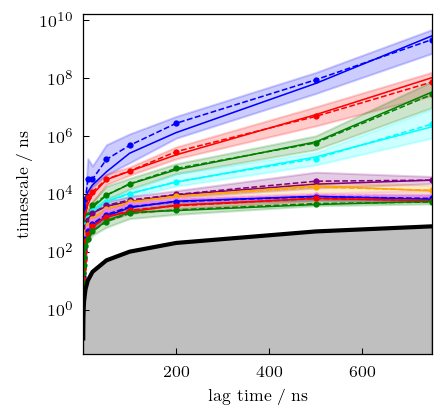

In [22]:
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, confidence=True, nits=10)

## 500 clusters

In [25]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=500)
km.fit(ivac_arr)

MiniBatchKMeans(n_clusters=500)

In [26]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [27]:
dtrajs = neighbors.kneighbors(ivac_arr, return_distance=False)

In [28]:
np.save("../../data/raw_feat/feat5_ivac_ind500_anton2_3.npy", dtrajs)

In [29]:
dtrajs = np.split(np.squeeze(dtrajs), traj_inds)

In [30]:
its = pyemma.msm.its(dtrajs, lags=lags, reversible=True, n_jobs=48, errors='bayes', nits=20)

100%|██████████| 13/13 [02:27<00:00, 11.34s/it]                        


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

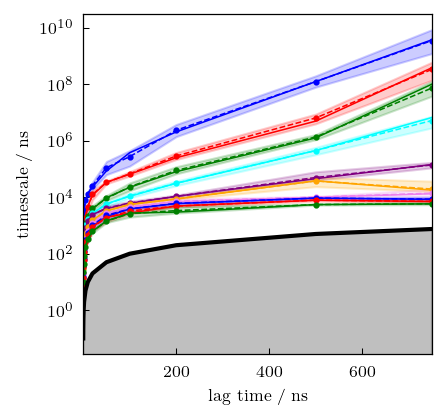

In [31]:
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, confidence=True, nits=10)

## 750 cluster

In [13]:
traj_inds = util.split_indices(cv_trajs)

In [16]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=750)
km.fit(ivac_arr)

MiniBatchKMeans(n_clusters=750)

In [17]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [18]:
dtrajs = neighbors.kneighbors(ivac_arr, return_distance=False)

In [14]:
# np.save("../../data/raw_feat/feat5_ivac_ind750_anton2_3.npy", dtrajs)
dtrajs = np.load("../../data/raw_feat/feat5_ivac_ind750_anton2_3.npy")

In [15]:
dtrajs = np.split(np.squeeze(dtrajs), traj_inds)

In [16]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 7500]
its = pyemma.msm.its(dtrajs, lags=lags, reversible=True, nits=10, n_jobs=48, errors='bayes')

100%|██████████| 13/13 [03:21<00:00, 15.50s/it]                        


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

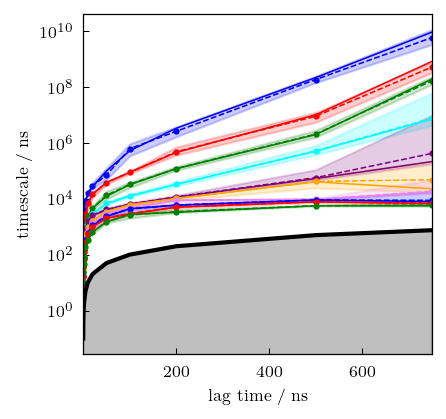

In [17]:
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, confidence=True, nits=10)

# Feat2

## IVAC

In [9]:
livac = ivac.LinearIVAC(minlag=1, maxlag=10000, nevecs=10, reweight=False, adjust=True)
livac.fit(sb_trajs)
feat2_ivac = livac.transform(sb_trajs)

In [12]:
feat2_ivac[0].shape

(10000, 10)

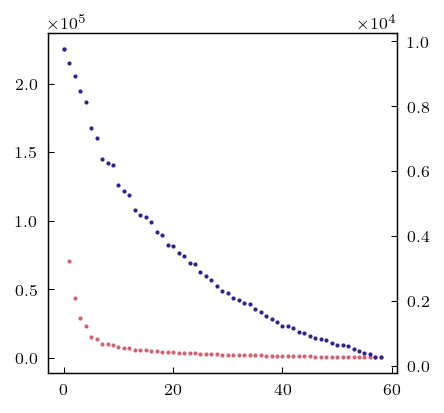

In [18]:
plt.plot(livac.its[1:], '.')
ax2 = plt.twinx()
ax2.plot(livac.evals[1:], '.', color='C1')

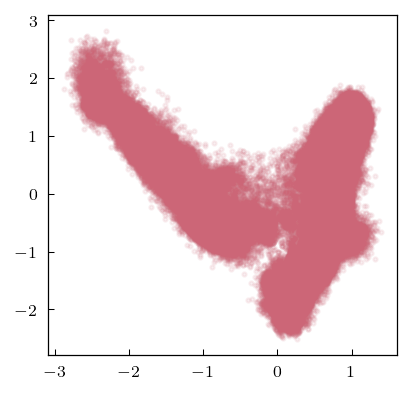

In [19]:
feat2_ivac_arr = np.concatenate(feat2_ivac)
plt.scatter(feat2_ivac_arr[::20, 1], feat2_ivac_arr[::20, 2], alpha=0.1)

In [20]:
np.save("../../data/raw_feat/feat2_ivac_anton2_3.npy", feat2_ivac)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## 200 clusters

In [21]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=200)
km.fit(feat2_ivac_arr)

MiniBatchKMeans(n_clusters=200)

In [22]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [23]:
dtrajs = neighbors.kneighbors(feat2_ivac_arr, return_distance=False)

In [24]:
np.save("../../data/raw_feat/feat2_ivac_ind200_anton2_3.npy", dtrajs)

In [26]:
traj_inds = util.split_indices(cv_trajs)

In [27]:
dtrajs = np.split(np.squeeze(dtrajs), traj_inds)

In [28]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
its = pyemma.msm.its(dtrajs, lags=lags, reversible=True, n_jobs=48, errors='bayes', nits=20)

100%|██████████| 16/16 [02:53<00:00, 10.86s/it]                        


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

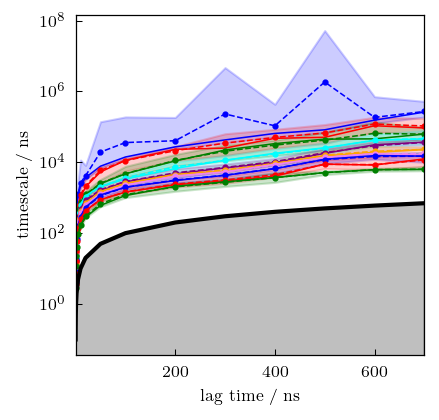

In [29]:
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, confidence=True, nits=10)

## 500 clusters

In [30]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=500)
km.fit(feat2_ivac_arr)

MiniBatchKMeans(n_clusters=500)

In [31]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [32]:
dtrajs = neighbors.kneighbors(feat2_ivac_arr, return_distance=False)

In [33]:
np.save("../../data/raw_feat/feat2_ivac_ind500_anton2_3.npy", dtrajs)

In [34]:
dtrajs = np.split(np.squeeze(dtrajs), traj_inds)

In [35]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
its = pyemma.msm.its(dtrajs, lags=lags, reversible=True, n_jobs=48, errors='bayes', nits=20)

100%|██████████| 16/16 [04:19<00:00, 16.24s/it]                          


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

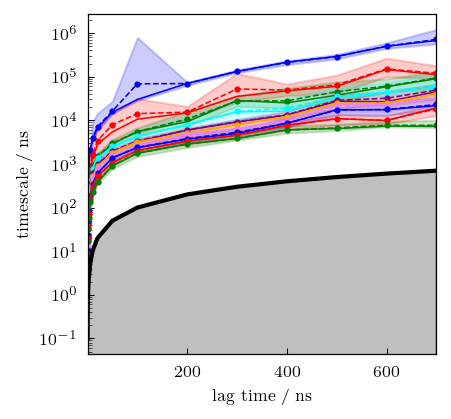

In [36]:
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, confidence=True, nits=10)

## 500 clusters, 5 IVAC dimensions

In [37]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=500)
km.fit(feat2_ivac_arr[:, 1:6])

MiniBatchKMeans(n_clusters=500)

In [38]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [40]:
dtrajs = neighbors.kneighbors(feat2_ivac_arr[:, 1:6], return_distance=False)

In [33]:
# np.save("../../data/raw_feat/feat2_ivac_ind500_anton2_3.npy", dtrajs)

In [41]:
dtrajs = np.split(np.squeeze(dtrajs), traj_inds)

In [42]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
its = pyemma.msm.its(dtrajs, lags=lags, reversible=True, n_jobs=48, errors='bayes', nits=20)

100%|██████████| 16/16 [04:15<00:00, 15.95s/it]                        


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

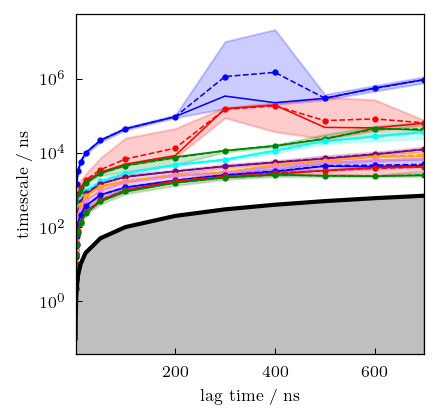

In [43]:
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, confidence=True, nits=10)